# 核函數支撐向量機(Kernel Support Vector Machine)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

##### 設定我們有60個點，其中30個是圈圈，30個是叉叉

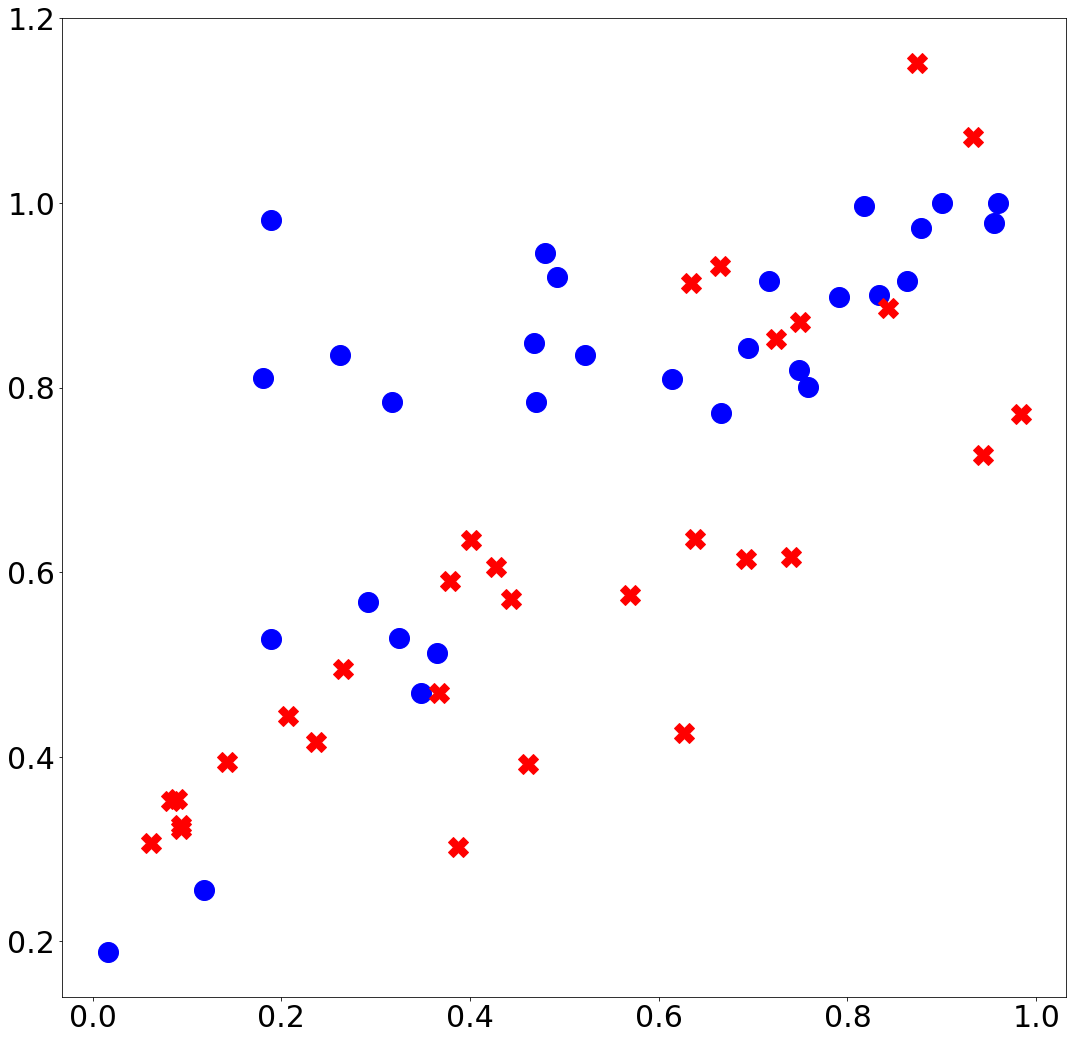

In [2]:
# 這裡我們建立一個60*2的矩陣x
# 60代表我們有60個點，2代表為2維空間(平面)
x=np.zeros((60,2))
# 這裡我們建立一個長度60的向量y
# 用來儲存我們的標記資料是圈圈(+1)還是叉叉(-1)
y=np.zeros(60)
# 因為有60筆資料，所以跑60個迴圈
for i in range(0,60): 
    # 標記y前半段0~29為圈圈(+1)，後半段30~59為叉叉(-1)
    # 也就是圈圈30個點，叉叉30個點
    f=-0.3
    if(i<30):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
    # 這裡我們隨機給定我們資料的位置
    # 而f可以決定我們圈圈和叉叉兩組數據分的越開或是越近
    
# 設定我們輸出圖片的大小
plt.rcParams["figure.figsize"] = (18,18)
#畫出圈圈的點，bo：b代表藍色、o代表圈圈、marksize為大小
plt.plot(x[:30,0],x[:30,1],"bo",markersize=20)
#畫出叉叉的點，rX：r代表紅色、X代表叉叉、marksize為大小
plt.plot(x[30:,0],x[30:,1],"rX",markersize=20)
# 設定x和y軸座標的字體大小
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#畫出來
plt.show()

# Polynomial Kernel

In [3]:
def Polynomial_kernel(x,xx,power,gamma,zeta):
    # 最後出來要為N*N的矩陣
    # 這裡可以對照文章公式
    return (zeta+gamma*np.dot(x,xx.T))**power

# QP for Polynomial Kernel

In [4]:
N=60
# c為次方數
c=15
gamma=1
zeta=1
# 二次規劃
Q = cvxopt.matrix((np.outer(y,y) * Polynomial_kernel(x,x,c,gamma,zeta)))
p = cvxopt.matrix(np.ones(N)*-1.,(N,1))
G = cvxopt.matrix(np.diag(np.ones(N)* -1.)) 
h = cvxopt.matrix(np.zeros(N))
A = cvxopt.matrix(y,(1,N))
b = cvxopt.matrix(0.0)
# 利用cvxopt套件求解
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['abstol'] = 1e-10
cvxopt.solvers.options['reltol'] = 1e-10
cvxopt.solvers.options['feastol'] = 1e-10
# 求出alpha值
a=np.array(cvxopt.solvers.qp(Q, p, G, h, A, b)['x']).flatten()
# 標記Support Vector
SV=[]
for i in range(0,N):
    if(a[i]>1e-6):
        SV.append(i)
# 計算b值
Com=0
s=SV[0]
for i in range(0,N):
    Com+=y[i]*a[i]*Polynomial_kernel(x[i,:],x[s,:],c,gamma,zeta)
b=y[s]-Com

# 視覺化(Polynomial Kernel)

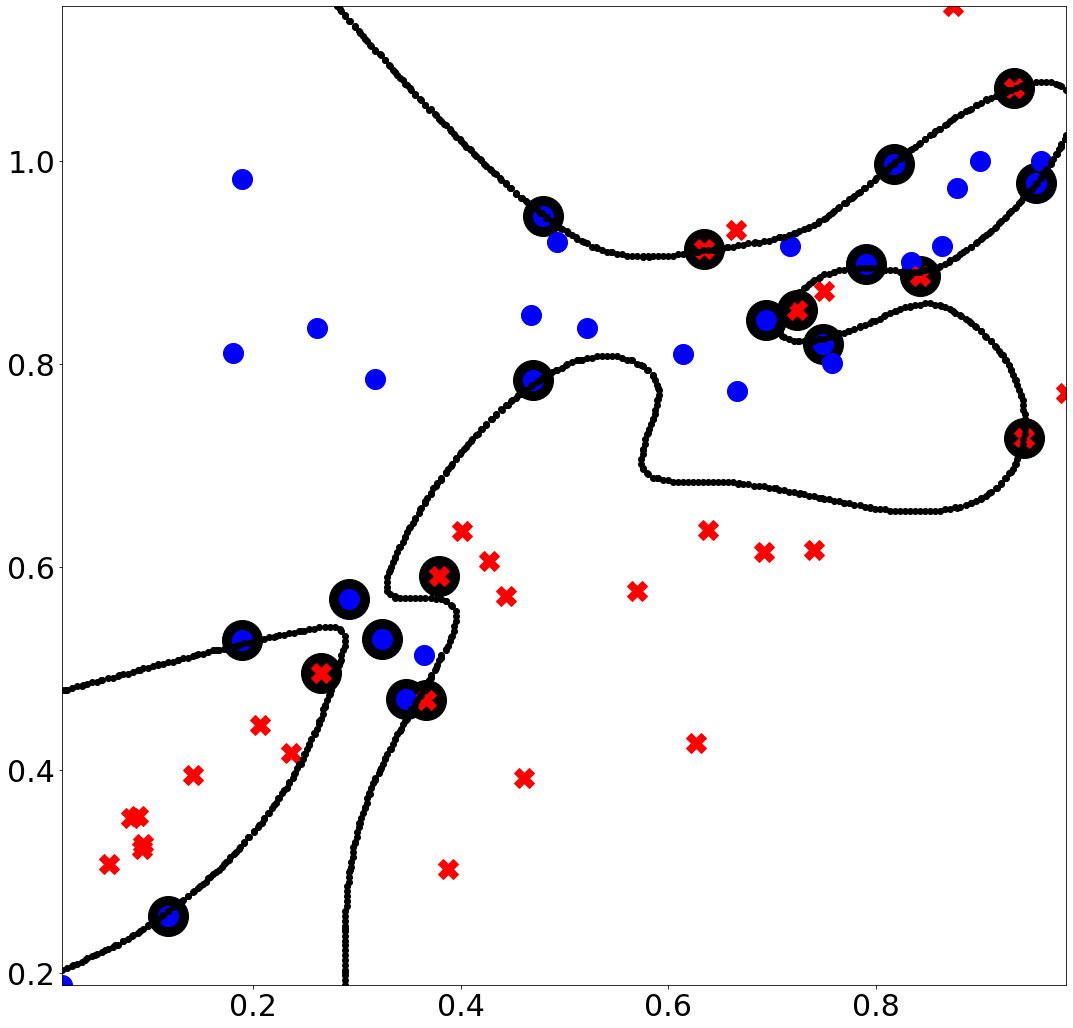

In [5]:
plt.rcParams["figure.figsize"] = (18,18)
# 畫出所有的數據點和支撐向量
for i in range(0,N):
    if(a[i]>1e-6):
        plt.plot(x[i,0],x[i,1],"ko",markersize=40)
plt.plot(x[:30,0],x[:30,1],"bo",markersize=20)
plt.plot(x[30:,0],x[30:,1],"rX",markersize=20)

#標記圖片邊界
x1_low_limit=min(x[:,0])
x1_high_limit=max(x[:,0])
x2_low_limit=min(x[:,1])
x2_high_limit=max(x[:,1])

# 畫出分割線
# 這裡的做法是
# 從x1最小值到x1最大值中間取200個點
# 從x2最小值到x2最大值中間取500個點
# 總共執行10000次，每次計算其套入分割線的方程式，並存入SUM
# 如果SUM從正變負或負變正，代表中間點為分割線
x1=np.linspace(x1_low_limit,x1_high_limit,200)
x2=np.linspace(x2_low_limit,x2_high_limit,500)

for i in x1:
    SUM_TEMP=0
    count=0
    for j in x2:
        SUM=0
        for k in SV:
            SUM+=a[k]*y[k]*Polynomial_kernel(np.array([i,j]),x[k,:],c,gamma,zeta)
        SUM+=b
        if(np.sign(SUM)!=np.sign(SUM_TEMP)):
            if(count>0):
                plt.plot(i,(x2[count]+x2[count-1])/2,"ko")
        count+=1
        SUM_TEMP=SUM
x1=np.linspace(x1_low_limit,x1_high_limit,500)
x2=np.linspace(x2_low_limit,x2_high_limit,200)
for j in x2:
    SUM_TEMP=0
    count=0
    for i in x1:
        SUM=0
        for k in SV:
            SUM+=a[k]*y[k]*Polynomial_kernel(np.array([i,j]),x[k,:],c,gamma,zeta)
        SUM+=b
        if(np.sign(SUM)!=np.sign(SUM_TEMP)):
            if(count>0):
                plt.plot((x1[count]+x1[count-1])/2,j,"ko")
        count+=1
        SUM_TEMP=SUM    

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim([x1_low_limit,x1_high_limit])
plt.ylim([x2_low_limit,x2_high_limit])
plt.show()

# Gaussian Kernel

In [6]:
def Gaussian_kernel(x,xx,gamma):
    # 這裡的做法是長度=2，代表他為1*2矩陣
    # 如果不是，代表長度為60*2的矩陣
    if(len(x)==2):
        Aa=(x**2).sum(axis=0)
        x_len=1
    else:
        Aa=(x**2).sum(axis=1)
        x_len=len(x)
    if(len(xx)==2):
        Bb=(xx**2).sum(axis=0)
        xx_len=1
    else:
        Bb=(xx**2).sum(axis=1)
        xx_len=len(xx)
    AA=Aa.reshape(x_len,1)
    BB=Bb.reshape(1,xx_len)
    return np.exp(-gamma*(AA+BB-2*np.dot(x,xx.T)))

# QP for Gaussian Kernel

In [7]:
N=60
gamma=1
# 二次規劃
Q = cvxopt.matrix((np.outer(y,y) * Gaussian_kernel(x,x,gamma)))
p = cvxopt.matrix(np.ones(N)*-1.,(N,1))
G = cvxopt.matrix(np.diag(np.ones(N)* -1.)) 
h = cvxopt.matrix(np.zeros(N))
A = cvxopt.matrix(y,(1,N))
b = cvxopt.matrix(0.0)
# 利用cvxopt套件求解
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['abstol'] = 1e-10
cvxopt.solvers.options['reltol'] = 1e-10
cvxopt.solvers.options['feastol'] = 1e-10

# 求出alpha值
a=np.array(cvxopt.solvers.qp(Q, p, G, h, A, b)['x']).flatten()
SV=[]
for i in range(0,N):
    if(a[i]>1e-6):
        SV.append(i)
Com=0
s=SV[0]
for i in range(0,N):
    Com+=y[i]*a[i]*Gaussian_kernel(x[i,:],x[s,:],gamma)
b=y[s]-Com

# 視覺化(Gaussian Kernel)

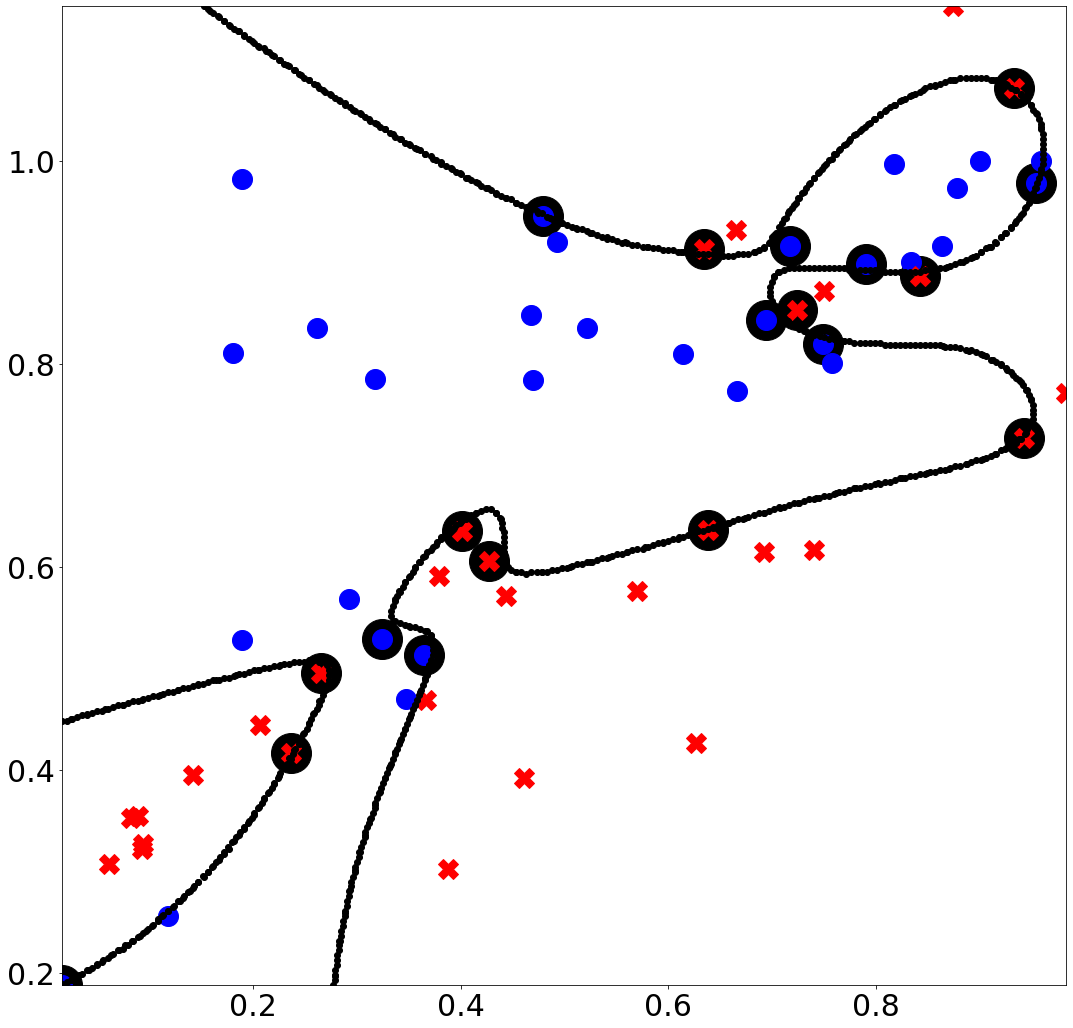

In [8]:
plt.rcParams["figure.figsize"] = (18,18)

# 畫出所有的數據點和支撐向量
for i in range(0,N):
    if(a[i]>1e-6):
        plt.plot(x[i,0],x[i,1],"ko",markersize=40)
plt.plot(x[:30,0],x[:30,1],"bo",markersize=20)
plt.plot(x[30:,0],x[30:,1],"rX",markersize=20)

x1_low_limit=min(x[:,0])
x1_high_limit=max(x[:,0])
x2_low_limit=min(x[:,1])
x2_high_limit=max(x[:,1])

x1=np.linspace(x1_low_limit,x1_high_limit,200)
x2=np.linspace(x2_low_limit,x2_high_limit,500)

for i in x1:
    SUM_TEMP=0
    count=0
    for j in x2:
        SUM=0
        for k in SV:
            SUM+=a[k]*y[k]*Gaussian_kernel(np.array([i,j]),x[k,:],gamma)
        SUM+=b
        if(np.sign(SUM)!=np.sign(SUM_TEMP)):
            if(count>0):
                plt.plot(i,(x2[count]+x2[count-1])/2,"ko")
        count+=1
        SUM_TEMP=SUM
    
x1=np.linspace(x1_low_limit,x1_high_limit,500)
x2=np.linspace(x2_low_limit,x2_high_limit,200)
for j in x2:
    SUM_TEMP=0
    count=0
    for i in x1:
        SUM=0
        for k in SV:
            SUM+=a[k]*y[k]*Gaussian_kernel(np.array([i,j]),x[k,:],gamma)
        SUM+=b
        if(np.sign(SUM)!=np.sign(SUM_TEMP)):
            if(count>0):
                plt.plot((x1[count]+x1[count-1])/2,j,"ko")
        count+=1
        SUM_TEMP=SUM    

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim([x1_low_limit,x1_high_limit])
plt.ylim([x2_low_limit,x2_high_limit])
plt.show()